<a href="https://colab.research.google.com/github/pstansfeld/MemProtMD/blob/main/AF2_Weblogo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Installation
%%capture
import os, time, gc

if not os.path.isfile("READY"):
    os.chdir('/content/')
    !apt-get update && apt-get upgrade -y && apt-get install -y gzip pymol dssp
    !python -m pip install --upgrade pip -q
    !python -m pip install py3dmol
    !python -m pip install biopython
    !python -m pip install numba -q
    !python -m pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma
    os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
    os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
    os.makedirs("hhsuite", exist_ok=True)
    os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")
    if "hhsuite" not in os.environ['PATH']:
      os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"
    if not os.path.isfile("CONDA_READY"):
      !wget -qnc "https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-$(uname)-$(uname -m).sh"
      !bash Miniforge3-$(uname)-$(uname -m).sh -bfp /usr/local
      !conda install -c bioconda weblogo -y -q
      os.system("touch CONDA_READY")
    os.system("touch READY")

In [7]:
#@title Initialisation
#%%capture
import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import string
import numpy as np
from Bio import SeqIO
from colabfold_utils import run_mmseqs2
from colabdesign.af.contrib import predict
from pickle import FALSE
from sys import version_info
import matplotlib.pyplot as plt
from PIL import Image
from numba import cuda
import matplotlib.pyplot as plt
import shutil
import numpy as np
import py3Dmol
import os
import sys
import requests
from Bio.PDB import PDBParser, PDBIO
from Bio.PDB.StructureBuilder import StructureBuilder
from google.colab import files


#@markdown ---
#@markdown #### Upload a single subunit protein or download from the AlphaFold Database (AFDB):
File_Location = "AFDB" #@param ["Upload","AFDB"]

#@markdown ---
#@markdown #### Enter a Job Name:
jobname = "LpsA" #@param {type:"string"}

#@markdown ---
#@markdown #### If using the AFDB enter the UniProtKB ID:
UniProtID = "P00804" #@param {type:"string"}
#@markdown ---

sys.path.append('/usr/local/lib/python3.7/site-packages/')

os.chdir('/content/')
name = str(UniProtID.upper())

if File_Location == "Upload":
    upload = files.upload()
    filename = next(iter(upload))
elif File_Location == "AFDB":
    os.system(f'wget https://alphafold.ebi.ac.uk/files/AF-{name}-F1-model_v4.pdb')
    filename = name + '.pdb'
    os.rename(f'AF-{name}-F1-model_v4.pdb', filename)

def py3dmol_view(pdbfilename, working_dir):
    mview = py3Dmol.view(width=800, height=400)
    with open(working_dir + pdbfilename, "r") as f:
        mol1 = f.read()
    mview.addModel(mol1, "pdb")
    mview.setStyle({"cartoon": {"color": "spectrum"}})
    mview.setStyle({'resn': 'DUM'}, {'sphere': {}})
    mview.setStyle({'atom': 'BB'}, {'sphere': {}})
    mview.setStyle({'atom': 'PO4'}, {'sphere': {}})
    mview.setStyle({'atom': 'P'}, {'sphere': {}})
    mview.setBackgroundColor("0xffffff")
    mview.zoomTo()
    mview.show()

with open(filename, 'r') as pdb_file:
    for record in SeqIO.parse(pdb_file, 'pdb-atom'):
        sequence = (str(record.seq))

/usr/local/lib/python3.10/dist-packages/Bio/SeqIO/PdbIO.py:322: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  warnings.warn(


jobname P00804_5a055
length=[164] copies=1
getting unpaired MSA


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


parsing msas
gathering info
filtering sequences
selecting final sequences


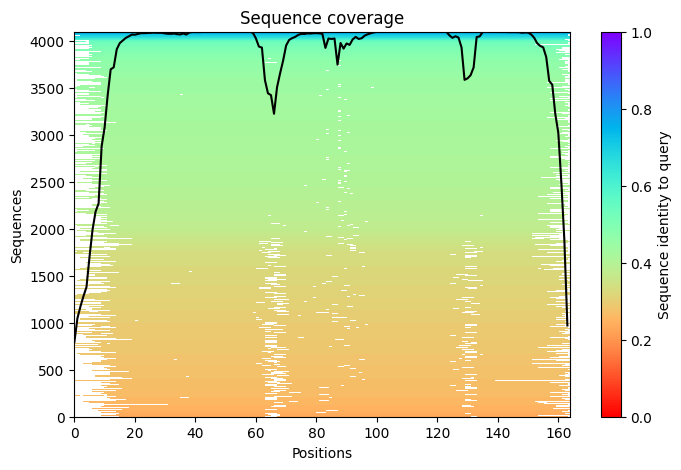

GC 9686


In [8]:
#@title Multiple Sequence Alignment
#%%capture

copies = 1
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 75 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90 #@param ["90", "100"] {type:"raw"}
qid = 0 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

jobname = f"{name}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

print("jobname",jobname)
print(f"length={u_lengths} copies={copies}")

input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":False,
              "propagate_to_copies":False}

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, name,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=run_mmseqs2_wrapper,
    hhfilter_fn=run_hhfilter)

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()

################
print("GC",gc.collect())

In [9]:
#@title Edit the a3m file

Maximum_number_of_sequences_to_use=99999 #@param {type:"integer"}

#define a function to get rid of the lower case guff in the AF a3m files
def a3mupper(mystring):

  newstring=""
  for character in mystring:
    if character.isupper() or character=="-":
      newstring=newstring+character
    else:
      pass
  newstring=newstring+"\n"
  return newstring

os.system(f"mv /content/{jobname}  /content/{name}")

#open the file from alphafold (msa.a3m) and check every line to get rid of the guff
myfile=open(f'/content/{name}/msa.a3m','r')
outfile=open(f'/content/{name}/editedmsa.a3m', 'w')

for line in myfile:
  if line[0] in ['>', '#','\r','\n']:
    pass
  else:
    editline=a3mupper(line)
    outfile.write(editline)

myfile.close() #
outfile.close()

#limit the number of sequences (option for reducing calculation time and computational burden)
myfile_to_chop=open(f'/content/{name}/editedmsa.a3m', 'r')
outfile_chopped=open(f'/content/{name}/trim_editedmsa.a3m','w')
count=0
for line in myfile_to_chop:
  if count<Maximum_number_of_sequences_to_use:
    outfile_chopped.write(line)
    count=count+1
  else:
    pass


myfile_to_chop.close()
outfile_chopped.close()

#get the topmost sequence from the msa
alignment_file=open(f'/content/{name}/trim_editedmsa.a3m', 'r')
alignments_list=alignment_file.readlines()
top_sequence=alignments_list[0]
alignment_file.close()

os.chdir(f"/content/{name}/")

!egrep -v '#|>' trim_editedmsa.a3m | sed 's/[a-z]//g' | sort -u > paired.aln

os.system(f"cp paired.aln {name}.aln")

0

Image loaded successfully. Dimensions: 1958x1475, Mode: RGB


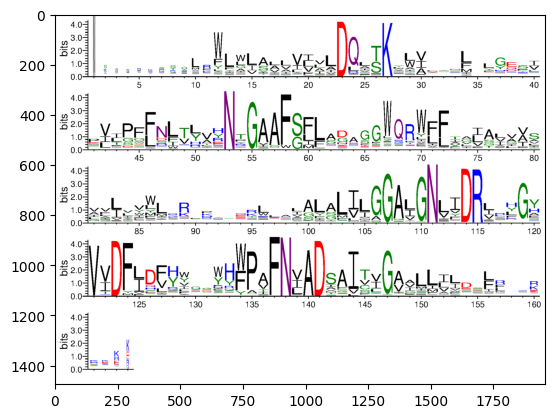

In [20]:
#@title Run WebLogo: Conservation of protein{ display-mode: "form" }

python_version = f"{version_info.major}.{version_info.minor}"
PYTHON_VERSION = python_version

os.chdir(f"/content/{name}/")

zip_file_path = f"/content/{name}/msa.result.zip"
target_folder = f"/content/{name}/"

#device = cuda.get_current_device()
#device.reset()

!mkdir -p output_folder
!weblogo --format PDF --color-scheme chemistry --errorbars NO --fineprint '' --resolution 300 < paired.aln > weblogo.pdf
!weblogo --format PNG --color-scheme chemistry --errorbars NO --fineprint '' --resolution 300 < paired.aln > weblogo.png
!weblogo --format logodata < paired.aln > weblogo.txt

os.system(f"mv weblogo.png {name}-weblogo.png")
os.system(f"mv weblogo.pdf {name}-weblogo.pdf")
os.system(f"mv weblogo.txt {name}-weblogo.txt")

# Provide the path to your uploaded image
image_path = f"/content/{name}/{name}-weblogo.png"
image = Image.open(image_path)
width = 600
height = 1200
# Display image properties (width, height, mode)
width, height = image.size
mode = image.mode
print(f"Image loaded successfully. Dimensions: {width}x{height}, Mode: {mode}")
image.show()

# Display the image using Matplotlib
plt.imshow(image)
#plt.axis('off')  # Hide axes for a cleaner look
#plt.show()
#weblogo_path = os.path.join(target_folder, "weblogo.txt")
#if os.path.exists(weblogo_path):
#    with open(weblogo_path, "r") as weblogo_file:
#        weblogo_contents = weblogo_file.read()
#        print("Contents of weblogo.txt:")
#        print(weblogo_contents)
#else:
#    print("weblogo.txt not found in the extracted contents.")

In [ ]:
# @title PDB File loader.
# @markdown This code will take an alphafold model of your protein and ajoin the conservation data after squaring for visualisation purposes (max 9 , min 0 ), to the b factor. Thus allowing you to visualise conservation in 3D, when using protein viewing software such as PyMOL. Use of the preset 'B factor putty' is one example of this. **In our representation, Blue is highly conserved and Red less conserved**.

name = str(UniProtID.upper())
os.system(f'wget https://alphafold.ebi.ac.uk/files/AF-{name}-F1-model_v4.pdb')
filename = f'{name}_AF2.pdb'
os.rename(f'AF-{name}-F1-model_v4.pdb', filename)

# Define the input PDB file and weblogo.txt file
pdb_filename = f'{name}_AF2.pdb'
weblogo_filename = f'{name}-weblogo.txt'

# Read entropy values from weblogo.txt
entropy_values = []
with open(weblogo_filename, 'r') as weblogo_file:
    for line in weblogo_file:
        if not line.startswith("#"):
            data = line.split()
            entropy = float(data[-4])  # Extract entropy value (4th from the end)
            entropy_values.append(entropy)

# Read the PDB file
parser = PDBParser(QUIET=True)
structure = parser.get_structure('protein', pdb_filename)

# Modify the beta factor of atoms based on entropy values
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                residue_index = residue.id[1] - 1  # Adjust for 0-based index
                if residue_index < len(entropy_values):
                    beta_factor = entropy_values[residue_index] ** 2  # Square the entropy value
                    atom.set_bfactor(beta_factor)

# Save the modified PDB file
output_filename = pdb_filename.replace('_AF2.pdb', '_weblogo.pdb')
io = PDBIO()
io.set_structure(structure)
io.save(output_filename)
# @title Display 3D structure {run: "auto"}

def show_pdb(pdb_filename, show_sidechains=False, show_mainchains=False, color="lDDT"):
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
    view.addModel(open(pdb_filename, 'r').read(), 'pdb')

    if color == "lDDT":
        view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 0.0, 'max': 10}}})
    elif color == "rainbow":
        view.setStyle({'cartoon': {'color': 'spectrum'}})
    elif color == "chain":
        chains = len(queries[0][1]) + 1 if is_complex else 1

        for n, chain, color in zip(range(chains), alphabet_list, pymol_color_list):
            view.setStyle({'chain': chain}, {'cartoon': {'color': color}})

    if show_sidechains == True :
        BB = ['C', 'O', 'N']
        view.addStyle({'and': [{'resn': ["GLY", "PRO"], 'invert': True}, {'atom': BB, 'invert': True}]},
                      {'stick': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 0.0, 'max': 10}, 'radius': 0.3}})
        view.addStyle({'and': [{'resn': "GLY"}, {'atom': 'CA'}]},
                      {'sphere': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 0.0, 'max': 10}, 'radius': 0.3}})
        view.addStyle({'and': [{'resn': "PRO"}, {'atom': ['C', 'O'], 'invert': True}]},
                      {'stick': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 0.0, 'max': 10}, 'radius': 0.3}})

    if show_mainchains:
        BB = ['C', 'O', 'N', 'CA']
        view.addStyle({'atom': BB}, {'stick': {'colorscheme': f"WhiteCarbon", 'radius': 0.3}})
        view.zoomTo()
    return view

# Visualize the file `my_protein.pdb`.
view = show_pdb(f"{output_filename}", show_sidechains=True, show_mainchains=True, color="lDDT")
view.show()
print('Dark blue - High Entropy/Conservation amino acids, Red - Low Entropy/Conservation amino acids. ')
print('You have downloaded the above structure as a pdb, with loaded b factors. However you can visualise the b factors coloured above. ')


In [ ]:
#@title Write a PyMOL script to visualise the data
#@markdown

os.chdir(f"/content/{name}")

with open("visualise.pml", "w") as script_file:
    script_file.write(f"""
import sys
from pymol import cmd
from pmg_tk.startup.apbs_gui.creating import pdb2pqr_cli
from pmg_tk.startup.apbs_gui.electrostatics import map_new_apbs

cmd.load(f"{name}_AF2.pdb", "alphafold")
cmd.load(f"{name}_weblogo.pdb", "conservation")

pdb2pqr_cli("electrostatics", "alphafold", options=["--ff", "amber"])
map_new_apbs("apbs_map01", "electrostatics")

cmd.ramp_new("apbs_ramp01", "apbs_map01", [-5, 0, 5])
cmd.set("surface_ramp_above_mode", 1, "electrostatics")
cmd.set("surface_color", "apbs_ramp01", "electrostatics")
cmd.hide()

cmd.create("hydrophobicity", "electrostatics")
cmd.alter("resname ALA and hydrophobicity", "b=-0.13692946")
cmd.alter("resname ARG and hydrophobicity","b=-0.41493776")
cmd.alter("resname ASN and hydrophobicity","b=-0.17842324")
cmd.alter("resname ASP and hydrophobicity","b=-1.00000000")
cmd.alter("resname CYS and hydrophobicity","b=-0.09128631")
cmd.alter("resname GLN and hydrophobicity","b=-0.07883817")
cmd.alter("resname GLU and hydrophobicity","b=-0.66804979")
cmd.alter("resname GLY and hydrophobicity","b=-0.47302905")
cmd.alter("resname HIS and hydrophobicity","b=-0.56846473")
cmd.alter("resname ILE and hydrophobicity","b=0.33609959")
cmd.alter("resname LEU and hydrophobicity","b=0.28630705")
cmd.alter("resname LYS and hydrophobicity","b=-0.75103734")
cmd.alter("resname MET and hydrophobicity","b=0.18257261")
cmd.alter("resname PHE and hydrophobicity","b=0.24066390")
cmd.alter("resname PRO and hydrophobicity","b=0.12863071")
cmd.alter("resname SER and hydrophobicity","b=-0.13692946")
cmd.alter("resname THR and hydrophobicity","b=-0.04564315")
cmd.alter("resname TRP and hydrophobicity","b=0.09958506")
cmd.alter("resname TYR and hydrophobicity","b=-0.09543568")
cmd.alter("resname VAL and hydrophobicity","b=0.21991701")

cmd.spectrum("b", "cyan white gold", "hydrophobicity", maximum=1, minimum=-1)
cmd.spectrum("b", "forest white purple", "conservation", maximum=3, minimum=0)

cmd.set_color("n0", "[0.051, 0.341, 0.827]")
cmd.set_color("n1", "[0.416, 0.796, 0.945]")
cmd.set_color("n2", "[0.996, 0.851, 0.212]")
cmd.set_color("n3", "[0.992, 0.490, 0.302]")
cmd.color("n0", "b < 100 and alphafold")
cmd.color("n1", "b < 90 and alphafold")
cmd.color("n2", "b < 70 and alphafold")
cmd.color("n3", "b < 50 and alphafold")

cmd.disable()
cmd.show("surface")
cmd.enable("alphafold")
cmd.enable("conservation")
cmd.enable("hydrophobicity")
cmd.enable("electrostatics")
cmd.set("grid_mode", 1)
""")
print("PyMOL script has been written to 'visualise.pml'")


In [ ]:
#@title Download

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

os.chdir("/content/")

# add settings file
settings_path = f"{name}/settings.txt"
with open(settings_path, "w") as text_file:
  if "input_opts" in dir():
    for k,v in input_opts.items():
      text_file.write(f"{k}={v}\n")
  if "model_opts" in dir():
    for k,v in model_opts.items():
      text_file.write(f"{k}={v}\n")
  if "run_opts" in dir():
    for k,v in run_opts.items():
      text_file.write(f"{k}={v}\n")
# --- Download the predictions ---
os.system(f"zip -r {name}.zip {name}")
files.download(f'{name}.zip')